<a href="https://colab.research.google.com/github/s89ne/enpc-highdimstats/blob/main/Y_intercept_coding_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General research process and resuls:

To tackle this problem, I tried several approaches that didn't turn out successful in accurately predicting the evolution of prices when I backtested them.

To start, I will briefly describe the main considered approaches:

1.The first, most straightforward approach I decided to initially try was a linear regression. The used loss was:
$$L = \sum_i \frac{|y_{pred}^i - y_{true}^i|}{y_{true}^i} $$
While I was able to achieve a very small loss with this approach, I couldn't accurately predict the direction of evolution of the price, which is the crucial information for deciding, in a broader strategy, if one should buy or sell stock. $$ $$
Achieving a small loss with a time series like this one isn't actually difficult, as simply predicting the price $p_i$ at date $i$ with $p_{i-1}$ leads to a small loss, but it doesn't perform better than randomness in predicting in which direction the market evolves.$$ $$
2.To try to train a model to specifically accurately predict the direction of evolution of the market, I tried a logistic regression. I tried to predict "0" if the price goes down and "1" if the price goes up. However, the obtained losses from this approach did not perform better than randomness (the accuracies were around $50%$). $$ $$
As performing extensive cross-validations is too expensive for my personal computer, I limited myself to pretty narrow cross-validations. This method could therefore prove to be better with better tuning of the hyperparameters.$$ $$
3.The third approach consisted of implementing a random forest binary classifier. But the results were not better.$$ $$
As performing extensive cross-validations is too expensive for my personal computer, I limited myself to pretty narrow cross-validations. This method could therefore prove to be better with better tuning of the hyperparameters.$$ $$
4.I tried several different Moving Average algorithms: The simple moving averages (SMA), the weighted moving averages (WMA), and the famous Autoregressive integrated moving average (ARIMA). These different strategies also didn't perform well. Since I couldn't get convincing results on a few examples of stocks I randomly picked, and because of computational costs, I did not perform all the loss computations on the other stocks. $$ $$
As for points 2 and 3, cross-validation the hyperparameters (order of ARIMA, weights of WMA..) could lead to better results.

# Perspectives:
I was unfortunately not able, in the given time, to get accurate predictions of the movements of the market. Further investigations could be done with more cross-validations, and with exploiting technical tools such as chart patterns, indicators to identify trading signals.

Once the market's movement predicted better than randomness, a whole world of portfolio diversification opens to us. I unfortunately couldn't move to this step.


# Importing the revelant libraries:

In [153]:
import csv
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num

from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

from joblib import Parallel, delayed
import multiprocessing

In [6]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'Y-intercept'
  %cd /content/gdrive/My Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/Y-intercept


# Using the GPU for faster computations:

In [ ]:
#Use GPU 
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
print('using device:', device)

using device: cuda


# Pre-processing the data:

In [7]:
ticker_list = []
date_list = []
last_list = []
volume_list = []

with open('data.csv', 'r') as csv_file:
  reader = csv.reader(csv_file)

  next(reader)

  for row in reader:
    ticker_list.append(row[0])
    date_list.append(datestr2num(row[1])) # Convert the str dates to nums
    last_list.append(float(row[2]))
    volume_list.append(int(row[3]))

In [8]:
# Make the date_list start at 0
date_list = np.array(date_list)
date_list -= np.min(date_list)

In [9]:
data_dict = defaultdict(list)

for ticker, date, last, volume in zip(ticker_list, date_list, last_list, volume_list):
  data_dict[ticker].append((date, last, volume))

# Data normalization :

In [10]:
for ticker, data in data_dict.items():
  prices = [price for date, price, volume in data]
  volumes = [volume for date, price, volume in data]

  # Minimum and maximum values for prices and volumes
  min_price, max_price = min(prices), max(prices)
  min_volume, max_volume = min(volumes), max(volumes)

  # Normalize prices and volumes
  prices_normalized = [(price - min_price) / (max_price - min_price) + 1 for price in prices]
  volumes_normalized = [(volume - min_volume) / (max_volume - min_volume) for volume in volumes]

  normalized_data = []
  for i in range(len(data)):
    date = data[i][0]
    price = prices_normalized[i]
    volume = volumes_normalized[i]
    normalized_data.append((date, price, volume))
    
  data_dict[ticker] = normalized_data

In [154]:
def normalize(raw_price):
  # Normalize a raw price
  return (raw_price - min_price) / (max_price - min_price) + 1

def denormalize(normalized_price):
  # Denormalize an already normalized price
  return (normalized_price - 1)*(max_price - min_price) + min_price

# 1/ Logistic Regression

In [12]:
num_items = {ticker: len(data) for ticker, data in data_dict.items()}

train_dict = {}
val_dict = {}
test_dict = {}

for ticker, data in data_dict.items():
  num_train = int(0.7 * num_items[ticker])
  num_val = int(0.2 * num_items[ticker])
  num_test = num_items[ticker] - num_train - num_val

  train_dict[ticker] = data[:num_train]
  val_dict[ticker] = data[num_train:num_train+num_val]
  test_dict[ticker] = data[num_train+num_val:]

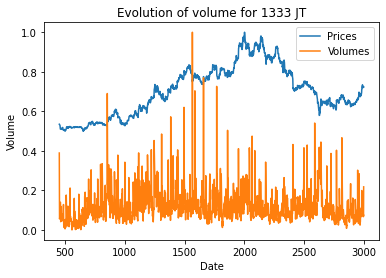

In [13]:
def visualize_prices(ticker, data_dict):
  data = data_dict[ticker]

  dates = [date for date, price, volume in data]

  prices = np.array([price for date, price, volume in data])
  prices = prices/np.max(prices)

  plt.plot(dates, prices)

  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title(f'Evolution of prices for {ticker}')

def visualize_volume(ticker, data_dict):
  data = data_dict[ticker]

  dates = [date for date, price, volume in data]

  volumes = np.array([volume for date, price, volume in data])
  volumes = volumes/np.max(volumes)
  

  plt.plot(dates, volumes)

  plt.xlabel('Date')
  plt.ylabel('Volume')
  plt.title(f'Evolution of volume for {ticker}')
  

visualize_prices('1333 JT', data_dict)
visualize_volume('1333 JT', data_dict)
plt.legend(["Prices", "Volumes"])

As we can see here, the line $i$ of the matrix $X$ represents the different parameters that will be used to predict the direction of evolution of the price of the stock "ticker" at the date $i$. 

$X[i]$ consists of the date $d_i$, the $n$ previous prices $(p_{i-n},\dots,p_{i-1})$ and the $n$ previous volumes $(v_{i-n},\dots,v_{i-1})$.

$Y$ is a vector consisting of ones and zeros, represention the direction of evolution of the prices at each date starting from $n$.

In [14]:
def get_data(ticker, input_dict, n=5):
  #returns the matrix X and the vector Y
  data = input_dict[ticker]

  dates = [date for date, price, volume in data]
  volumes = [volume for date, price, volume in data]
  prices = np.array([price for date, price, volume in data])

  # Shift volumes and prices by n time steps
  volumes_shifted = list()
  prices_previous = list()

  for i in range(len(prices) - n):
    volumes_shifted.append(volumes[i:i+n])
    prices_previous.append(prices[i:i+n])

  prices_current = prices[n:] > prices[n-1:-1]

  X = np.column_stack((dates[n:], volumes_shifted, prices_previous))

  y = prices_current.astype(int)
  
  return X, y

In [15]:
def regression_validation_loss(ticker):

  X_train, y_train = get_data(ticker, train_dict)
  X_val, y_val = get_data(ticker, val_dict)

  model = LogisticRegression(max_iter=1000)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  loss = np.mean(np.abs(y_pred - y_val))

  return [loss, model]

def all_regression_validation_losses(ticker_list):

  losses = list()
  models = list()
  for ticker in ticker_list:
    if(len(train_dict[ticker]) > 200):
      output = regression_validation_loss(ticker)
      losses.append(output[0])
      models.append(output[1])
    #else : 
      #losses.append(-1)
      #models.append(-1)
  return losses, models
regression_losses, regression_models = all_regression_validation_losses(train_dict.keys())

print(np.mean(np.array(regression_losses)))

0.4978449052835799


# 2/ Random forest binary classifier:


In [ ]:
def random_forest_validation_loss(ticker, n_estimators, random_state):
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

  X_test, y_test = get_data(ticker, train_dict)
  model.fit(X_test, y_test) 

  X_val, y_val = get_data(ticker, val_dict)

  y_pred = model.predict(X_val)

  loss = np.mean(np.abs(y_pred - y_val))

  return loss, model

In [ ]:
def all_random_forest_validation_losses(ticker_list, n_estimators_list, random_state_list):
  def process(ticker):
    best_score = 1e5
    best_n_estimators = None
    best_random_state = None
    best_model = None

    for n_estimators in n_estimators_list:
      for random_state in random_state_list:
        score, model = random_forest_validation_loss(ticker, n_estimators, random_state)
        if(score < best_score):
          best_score = score
          best_model = model
          best_n_estimators = n_estimators
          best_random_state = random_state
          
    return [best_score, best_model, best_n_estimators, best_random_state]
    
  num_cores = multiprocessing.cpu_count()
  result = list()

  #result = Parallel(n_jobs=num_cores)(delayed(process)(ticker) for ticker in ticker_list)

  for ticker in ticker_list:
    if(len(train_dict[ticker]) > 200):
      result.append(process(ticker))
    
  losses = [r[0] for r in result]
  models = [r[1] for r in result]
  best_n_estimators = [r[2] for r in result]
  best_random_state = [r[3] for r in result]

  return losses, models, best_n_estimators, best_random_state

n_estimators_list = [100]
random_state_list = [42]
random_forest_losses, random_forest_models, best_n_estimators, best_random_state = all_random_forest_validation_losses(train_dict.keys(), n_estimators_list, random_state_list)

print(np.mean(np.array(random_forest_losses)))

0.4998183136719491


# 3. Weighted Moving averages:

In [16]:
def get_data(ticker):
  data = data_dict[ticker]

  dates = []
  prices = []
  volumes = []

  for date, price, volume in data:
    dates.append(date)
    prices.append(price)
    volumes.append(volume)

  return dates, prices, volumes

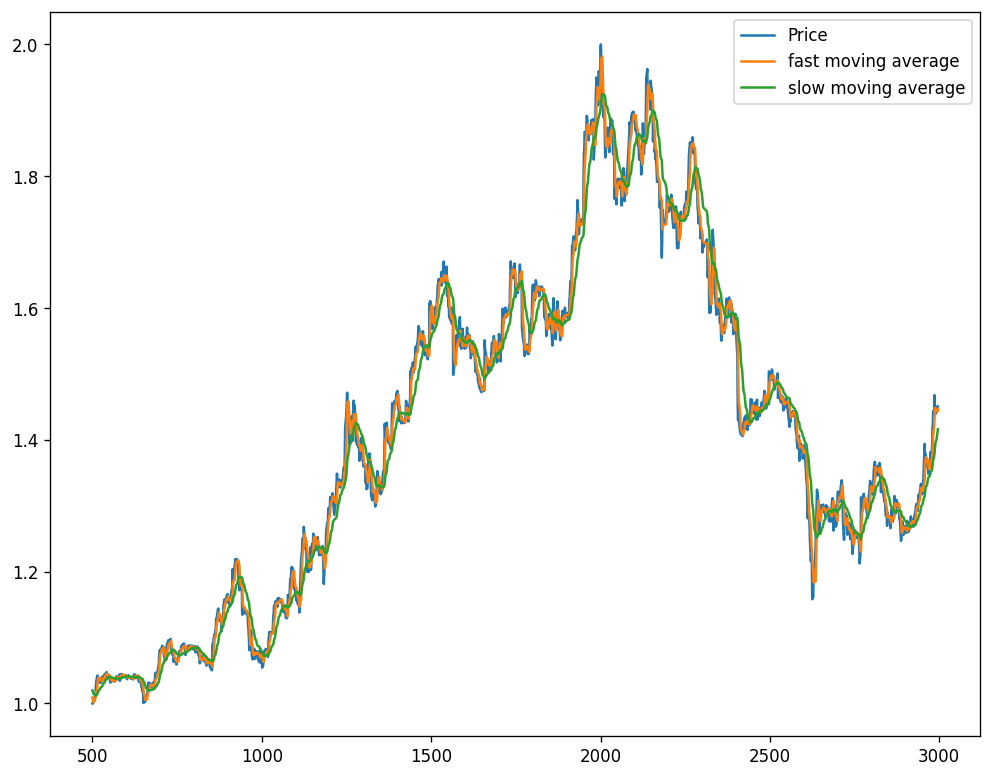

In [155]:
ticker_test = '1333 JT'

dates, prices, volumes = get_data(ticker_test)

# Set window sizes
window_size_1 = 5
window_size_2 = 30

# Set weights : 
weights_1 = [i+1 for i in range(window_size_1)]
weights_2 = [i+1 for i in range(window_size_2)]

moving_average_1 = []
moving_average_2 = []

corresponding_dates = []
corresponding_prices = []

for i in range(len(dates) - window_size_2):

  weighted_prices = [prices[i+(window_size_2 - window_size_1)+j] * weights_1[j] for j in range(window_size_1)]
  moving_average_1.append(sum(weighted_prices) / sum(weights_1))

  weighted_prices = [prices[i+j] * weights_2[j] for j in range(window_size_2)]
  moving_average_2.append(sum(weighted_prices) / sum(weights_2))

  corresponding_dates.append(dates[i+window_size_2])
  corresponding_prices.append(prices[i+window_size_2])

signals = []

for i in range(len(moving_average_1)):
  if moving_average_1[i] > moving_average_2[i]:
    signals.append(1)
  elif moving_average_1[i] < moving_average_2[i]:
    signals.append(-1)
  else:
    signals.append(0)

plt.figure(figsize = (10, 8))

plt.plot(corresponding_dates, corresponding_prices, label='Price')
plt.plot(corresponding_dates, moving_average_1, label='fast moving average')
plt.plot(corresponding_dates, moving_average_2, label='slow moving average')

plt.legend()
plt.show()

In [146]:
def test_profitability(signal, prices):
    # Initialize a portfolio and a balance
    portfolio = []
    balance = 100

    for i in range(len(signal)):
        # If the signal is 1, buy one share
        if signal[i] == 1:
            portfolio.append(prices[i])
            balance -= prices[i]
        # If the signal is -1, sell one share
        elif signal[i] == -1:
            if len(portfolio) > 0:
                balance += portfolio.pop()
                
    profit_loss = balance + sum(portfolio) - 100

    return profit_loss

In [147]:
print(test_profitability(signals, corresponding_prices))

2.4158453015843406e-13


# 4. Autoregressive integrated moving average (ARIMA):

In [169]:
# Create a dataframe with the dates, prices, and volumes
df = pd.DataFrame({'date': dates, 'price': prices})

In [170]:
df = df.set_index('date')
series = df['price']

In [171]:
lenght = len(dates) - 1
test_size = int(lenght * 0.2)

df_train = df[:lenght-test_size]
df_test = df[lenght-test_size:]

In [172]:
# Select the 'price' column from the dataframe and convert it to a series
train = df_train['price']
test = df_test['price']

We visualize the curves of "df_train" and its differentials to guess the difference component of the model.

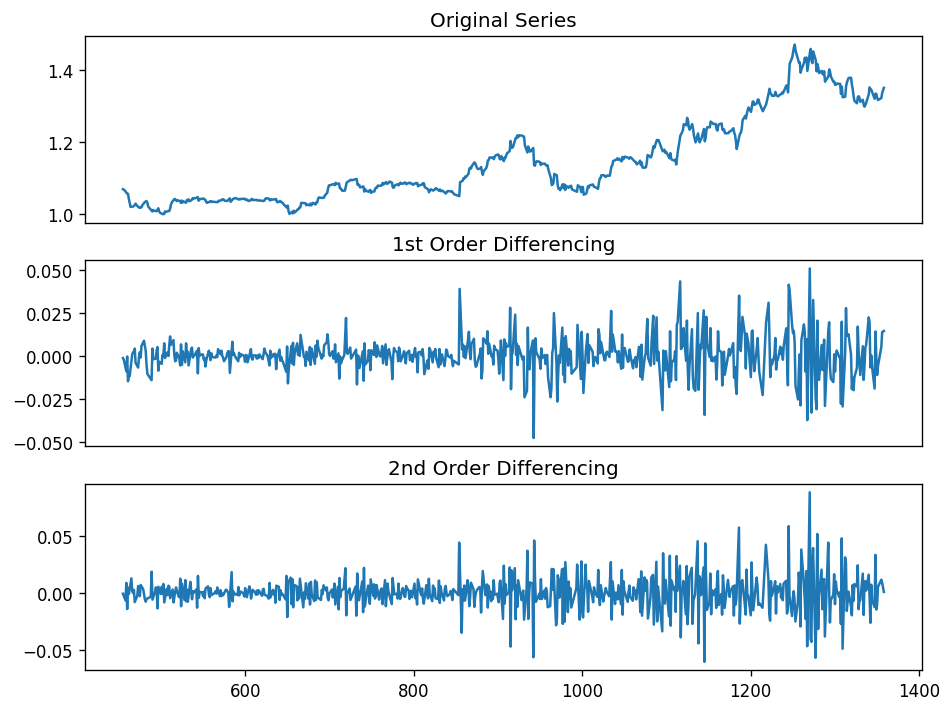

In [174]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_train); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_train.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_train.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [ ]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

right_predictions = 0
wrong_predictions = 0

signals = []

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2, 2, 1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	if(t >= 1):
		if(yhat > test[t-1]):
			signals.append(1)
		else:
			signals.append(-1)
	 
		if (yhat >= test[t-1] and obs >= test[t-1]) or (yhat <= test[t-1] and obs <= test[t-1]):
			right_predictions += 1
		else:
			wrong_predictions += 1
	if t%50 == 0 : 
		print('%d : right_predictions=%d, wrong_predictions=%d' % (int(t), right_predictions, wrong_predictions))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))

In [178]:
print(right_predictions, wrong_predictions)

292 286


Test RMSE: 0.016


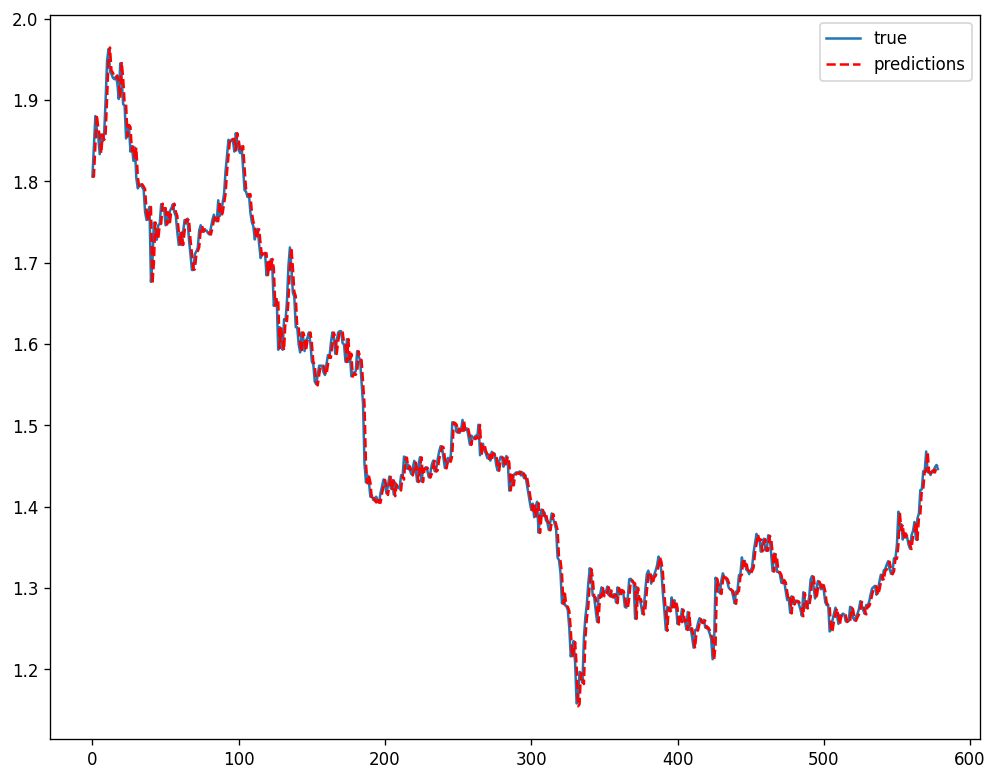

In [176]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (10, 8))
plt.plot(test, '-', label="true")
plt.plot(predictions, '--', color='red',label="predictions")
plt.legend()
plt.show()